# Figure 3: single-cell and development

## Setup

In [2]:
# Set working directory
%cd work/notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [3]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from single_cell import *
from brainspan import *

### Compute components

In [ ]:
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


---

# Fig 3

## Single cell analysis

Functions in `code/single_cell.py`.

Process single cell data from Allen Cell Atlas

In [ ]:
# weights_matched, matching_column_indices = get_single_cell_matching_genes(weights)
# weights_matched_posneg = get_weights_posneg(weights_matched)
# sc_projected_posneg = project_single_cell_posneg(weights_matched_posneg, matching_column_indices)

In [54]:
sc_projected_posneg_plot = format_single_cell_projected_for_plot()

In [55]:
sc_projected_posneg_plot

,class_label,subclass_label,region_label,layer,cell_type,outlier_call,C,negative,positive
24670,Glutamatergic,IT,CgG,L5,N-Ex,False,C2,1058.334064,974.552267
21858,Glutamatergic,L6 CT,V1C,L6,N-Ex,False,C3,598.787581,965.795091
21858,Glutamatergic,L6 CT,V1C,L6,N-Ex,False,C2,977.735877,1052.693880
21858,Glutamatergic,L6 CT,V1C,L6,N-Ex,False,C1,1834.407091,2386.259411
21857,Glutamatergic,L6 CT,V1C,L6,N-Ex,False,C3,579.076501,966.524894
...,...,...,...,...,...,...,...,...,...
25689,Non-neuronal,OPC,CgG,L2,OPC,False,C1,2257.335421,1861.556234
39929,Non-neuronal,OPC,M1ul,L3,OPC,False,C1,2127.236811,1994.992231
39929,Non-neuronal,OPC,M1ul,L3,OPC,False,C2,1111.883056,900.675606
38478,Non-neuronal,OPC,M1lm,L6,OPC,False,C2,920.943657,1025.822663


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


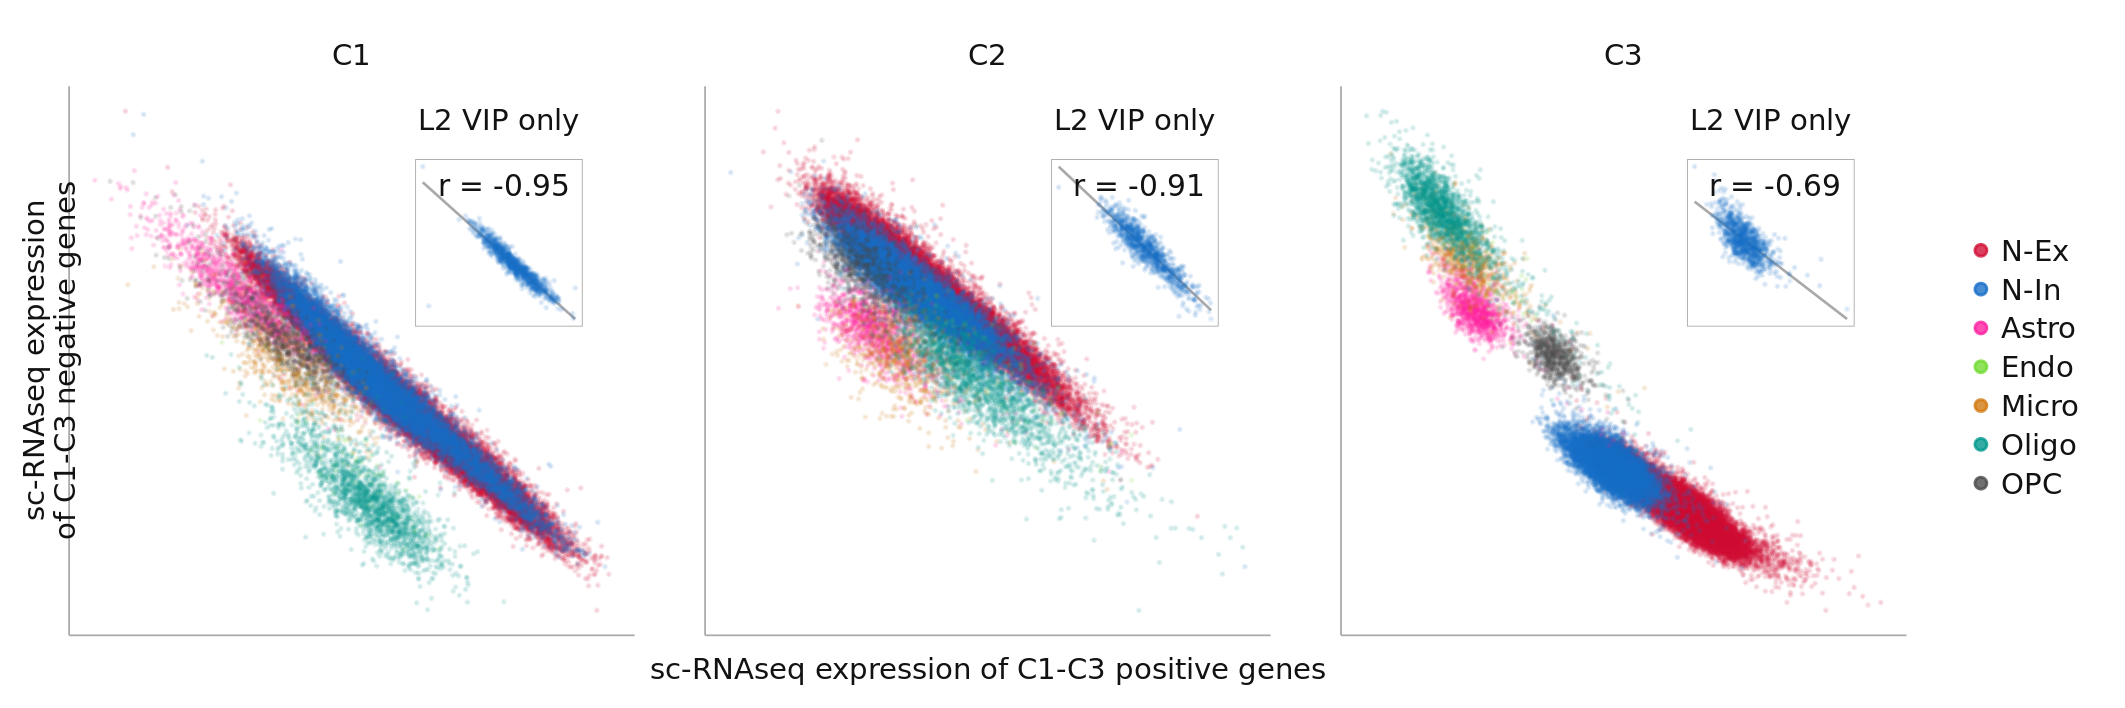

In [472]:
%%R -i sc_projected_posneg_plot -w 180 -h 60 -u mm -r 300
source("../code/fig3_plots.R")
plot_singlecell <- sc_projected_posneg_plot %>% plot_single_cell_posneg()
plot_singlecell

## BrainSpan analysis

Functions in `code/brainspan.py`.

### Brainspan mapping

In [58]:
hcp_bs_mapping = get_hcp_bs_mapping_v2()

In [59]:
bs_exp, bs_col, bs_row = get_brainspan()
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, hcp_bs_mapping)
bs_agg = aggregate_brainspan_by_age(bs_clean)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [60]:
bs_clean.groupby(['donor_id', 'age']).size().loc[lambda x: x>3].sort_index(level=1).shape

(35,)

In [65]:
(bs_clean.index.to_frame().reset_index(drop=True)
 .assign(age_group = lambda x: x['age'].map(get_age_groups()))
 .groupby('age_group').nunique()
)

,donor_id,gender,age,structure_name,structure_acronym
age_group,,,,,
18-40 yrs,8,2,8,11,11
Birth-13 yrs,14,2,10,11,11
Pre-Birth,20,2,13,11,11


### Brainspan development

In [66]:
hcp_mapped_scores = get_mapped_scores(dme_3d_ds5, hcp_bs_mapping)
bs_scores = compute_brainspan_scores(bs_agg, dme_3d_ds5)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [67]:
age_groups = get_age_groups()
bs_scores_corr = correlate_brainspan_scores(bs_scores, hcp_mapped_scores, age_groups=age_groups)

In [68]:
bs_scores_corr.sort_values('age')

,age,C,corr
0,Pre-Birth,C1,0.736832
3,Pre-Birth,C2,0.663407
6,Pre-Birth,C3,0.288453
1,Birth-13 yrs,C1,0.875437
4,Birth-13 yrs,C2,0.910673
7,Birth-13 yrs,C3,0.471215
2,18-40 yrs,C1,0.957717
5,18-40 yrs,C2,0.883534
8,18-40 yrs,C3,0.838816


### Brainspan adult correlation

In [69]:
both_scores, both_corrs = combine_scores(bs_scores, hcp_mapped_scores, age_groups)

In [70]:
scores_plot = make_brain_plots(dme_3d_ds5, hcp_bs_mapping, bs_scores).replace({'version':{'BrainSpan':'BrainSpan 18-40yrs'}})

`geom_smooth()` using formula = 'y ~ x'


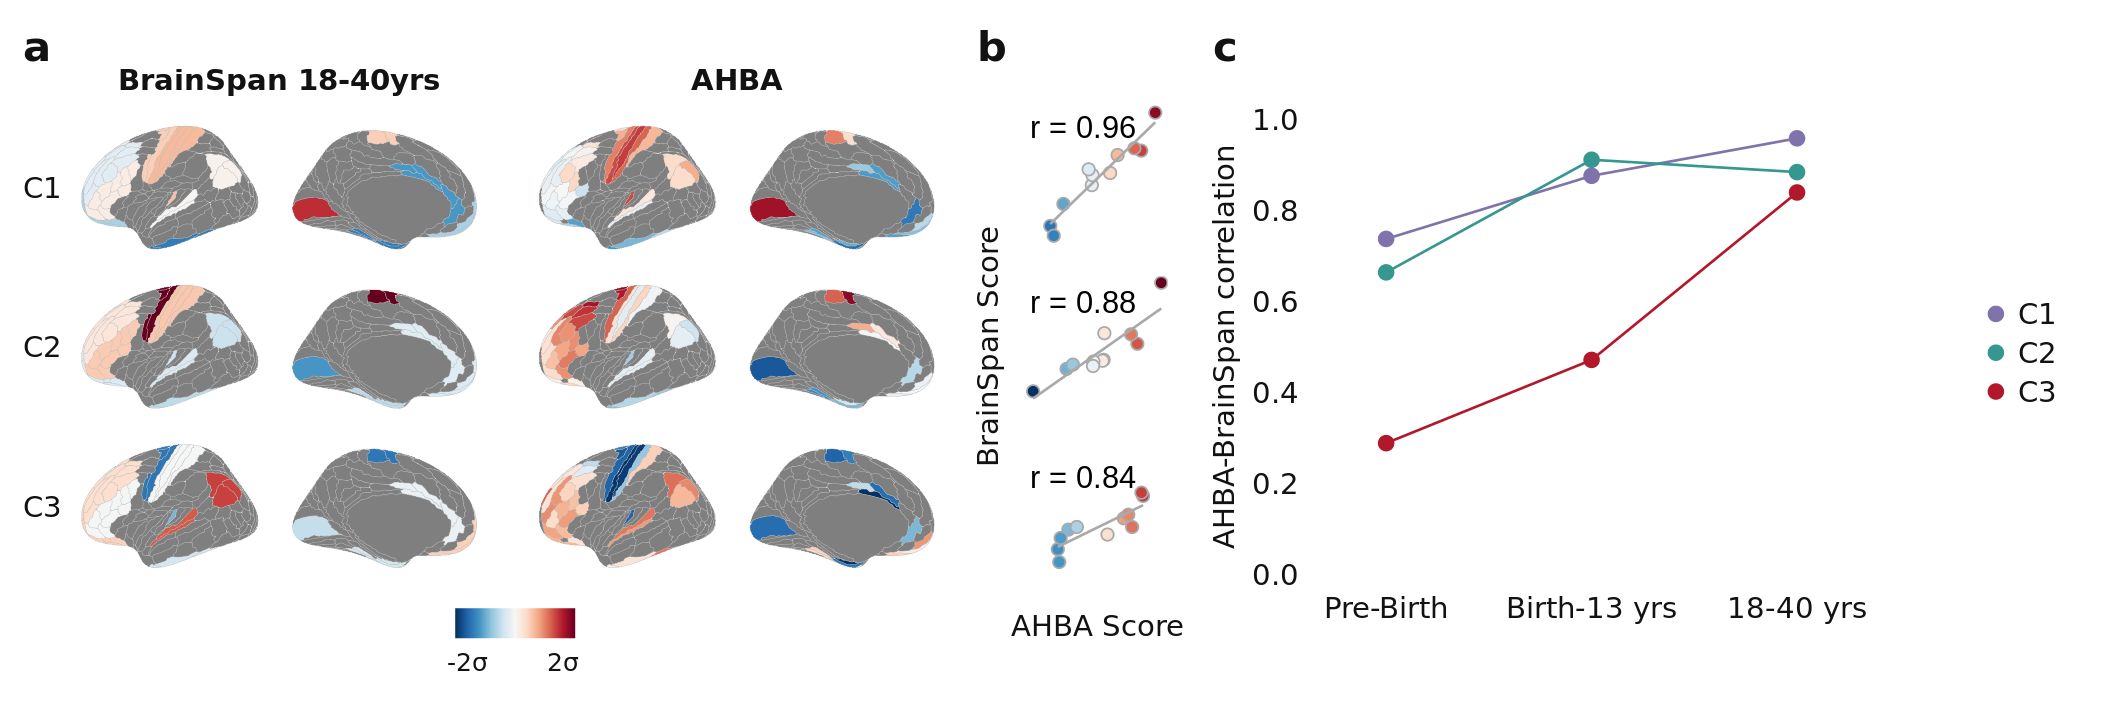

In [71]:
%%R -w 180 -h 60 -u mm -r 300 -i hcp_bs_mapping -i both_scores -i both_corrs -i scores_plot -i bs_scores_corr
source("../code/fig3_plots.R")

plot_brains <- plot_brain_maps(scores_plot,  switch='y') + theme(
            legend.position=c(.5,-.15),
            legend.direction='horizontal',
            panel.spacing.y = unit(2, 'mm')
            )

plot_scatter <- plot_ahba_bs_scatter(both_scores, both_corrs)
plot_dev_corr <- plot_bs_scores_corr(bs_scores_corr)

layout <- c(
    area(t=1,b=1,l=1,r=95),
    area(t=1,b=1,l=96,r=110),
    area(t=1,b=1,l=111,r=180)
)

plot <- plot_brains + plot_scatter + plot_dev_corr + plot_layout(design=layout)

plot_brainspan = plot + plot_annotation(tag_level='a')
plot_brainspan

### Age curves

In [72]:
curves = get_brainspan_curves_by_gene(genes=weights.index)

BrainSpan curves saved to ../outputs/brainspan_curves.csv


In [451]:
bs_donor_ages = (bs_clean
 .index.to_frame(index=False)
 .loc[:, ['age', 'donor_id']]
 .assign(age_log10 = lambda x: age_to_continuous(x['age']).pipe(np.log10))
 .groupby('donor_id').max()
 .sort_values('age')
 .assign(age_n = lambda x: x.groupby('age').cumcount())
)

In [73]:
quantile_curves = get_quantile_curves(weights, curves)
# quantile_curves

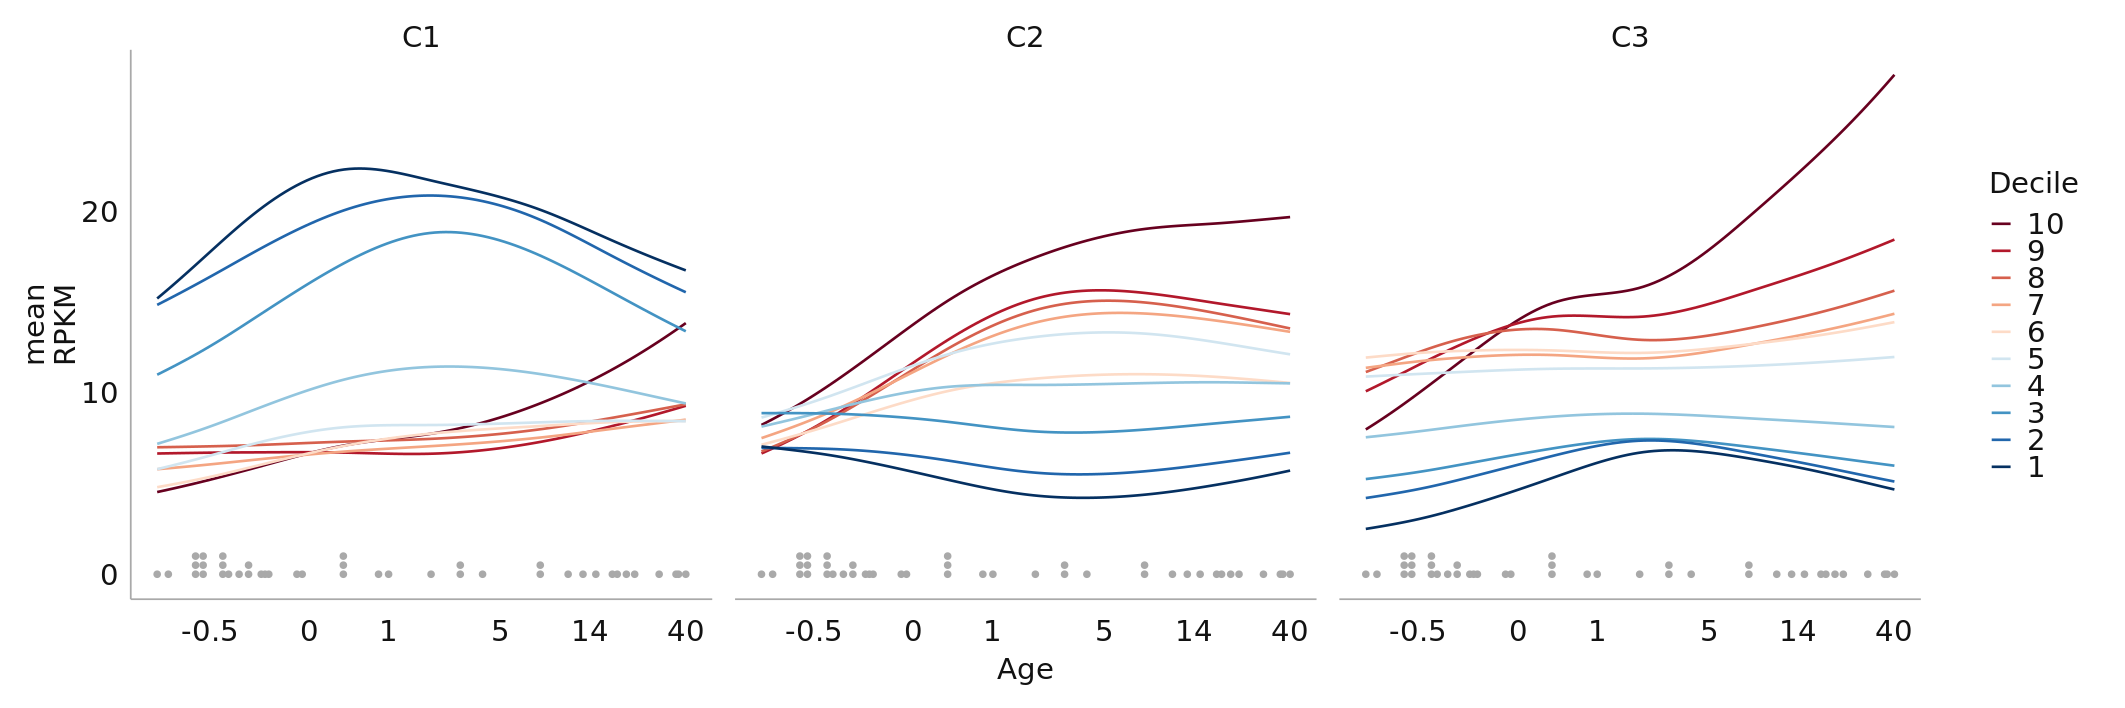

In [470]:
%%R -i quantile_curves -i bs_donor_ages -w 180 -h 60 -u mm -r 300
source("../code/fig3_plots.R")
library(ggh4x)
plot_curves <- quantile_curves %>% plot_quantile_curves(donor_ages=bs_donor_ages)
plot_curves 

## Combined Fig 3

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


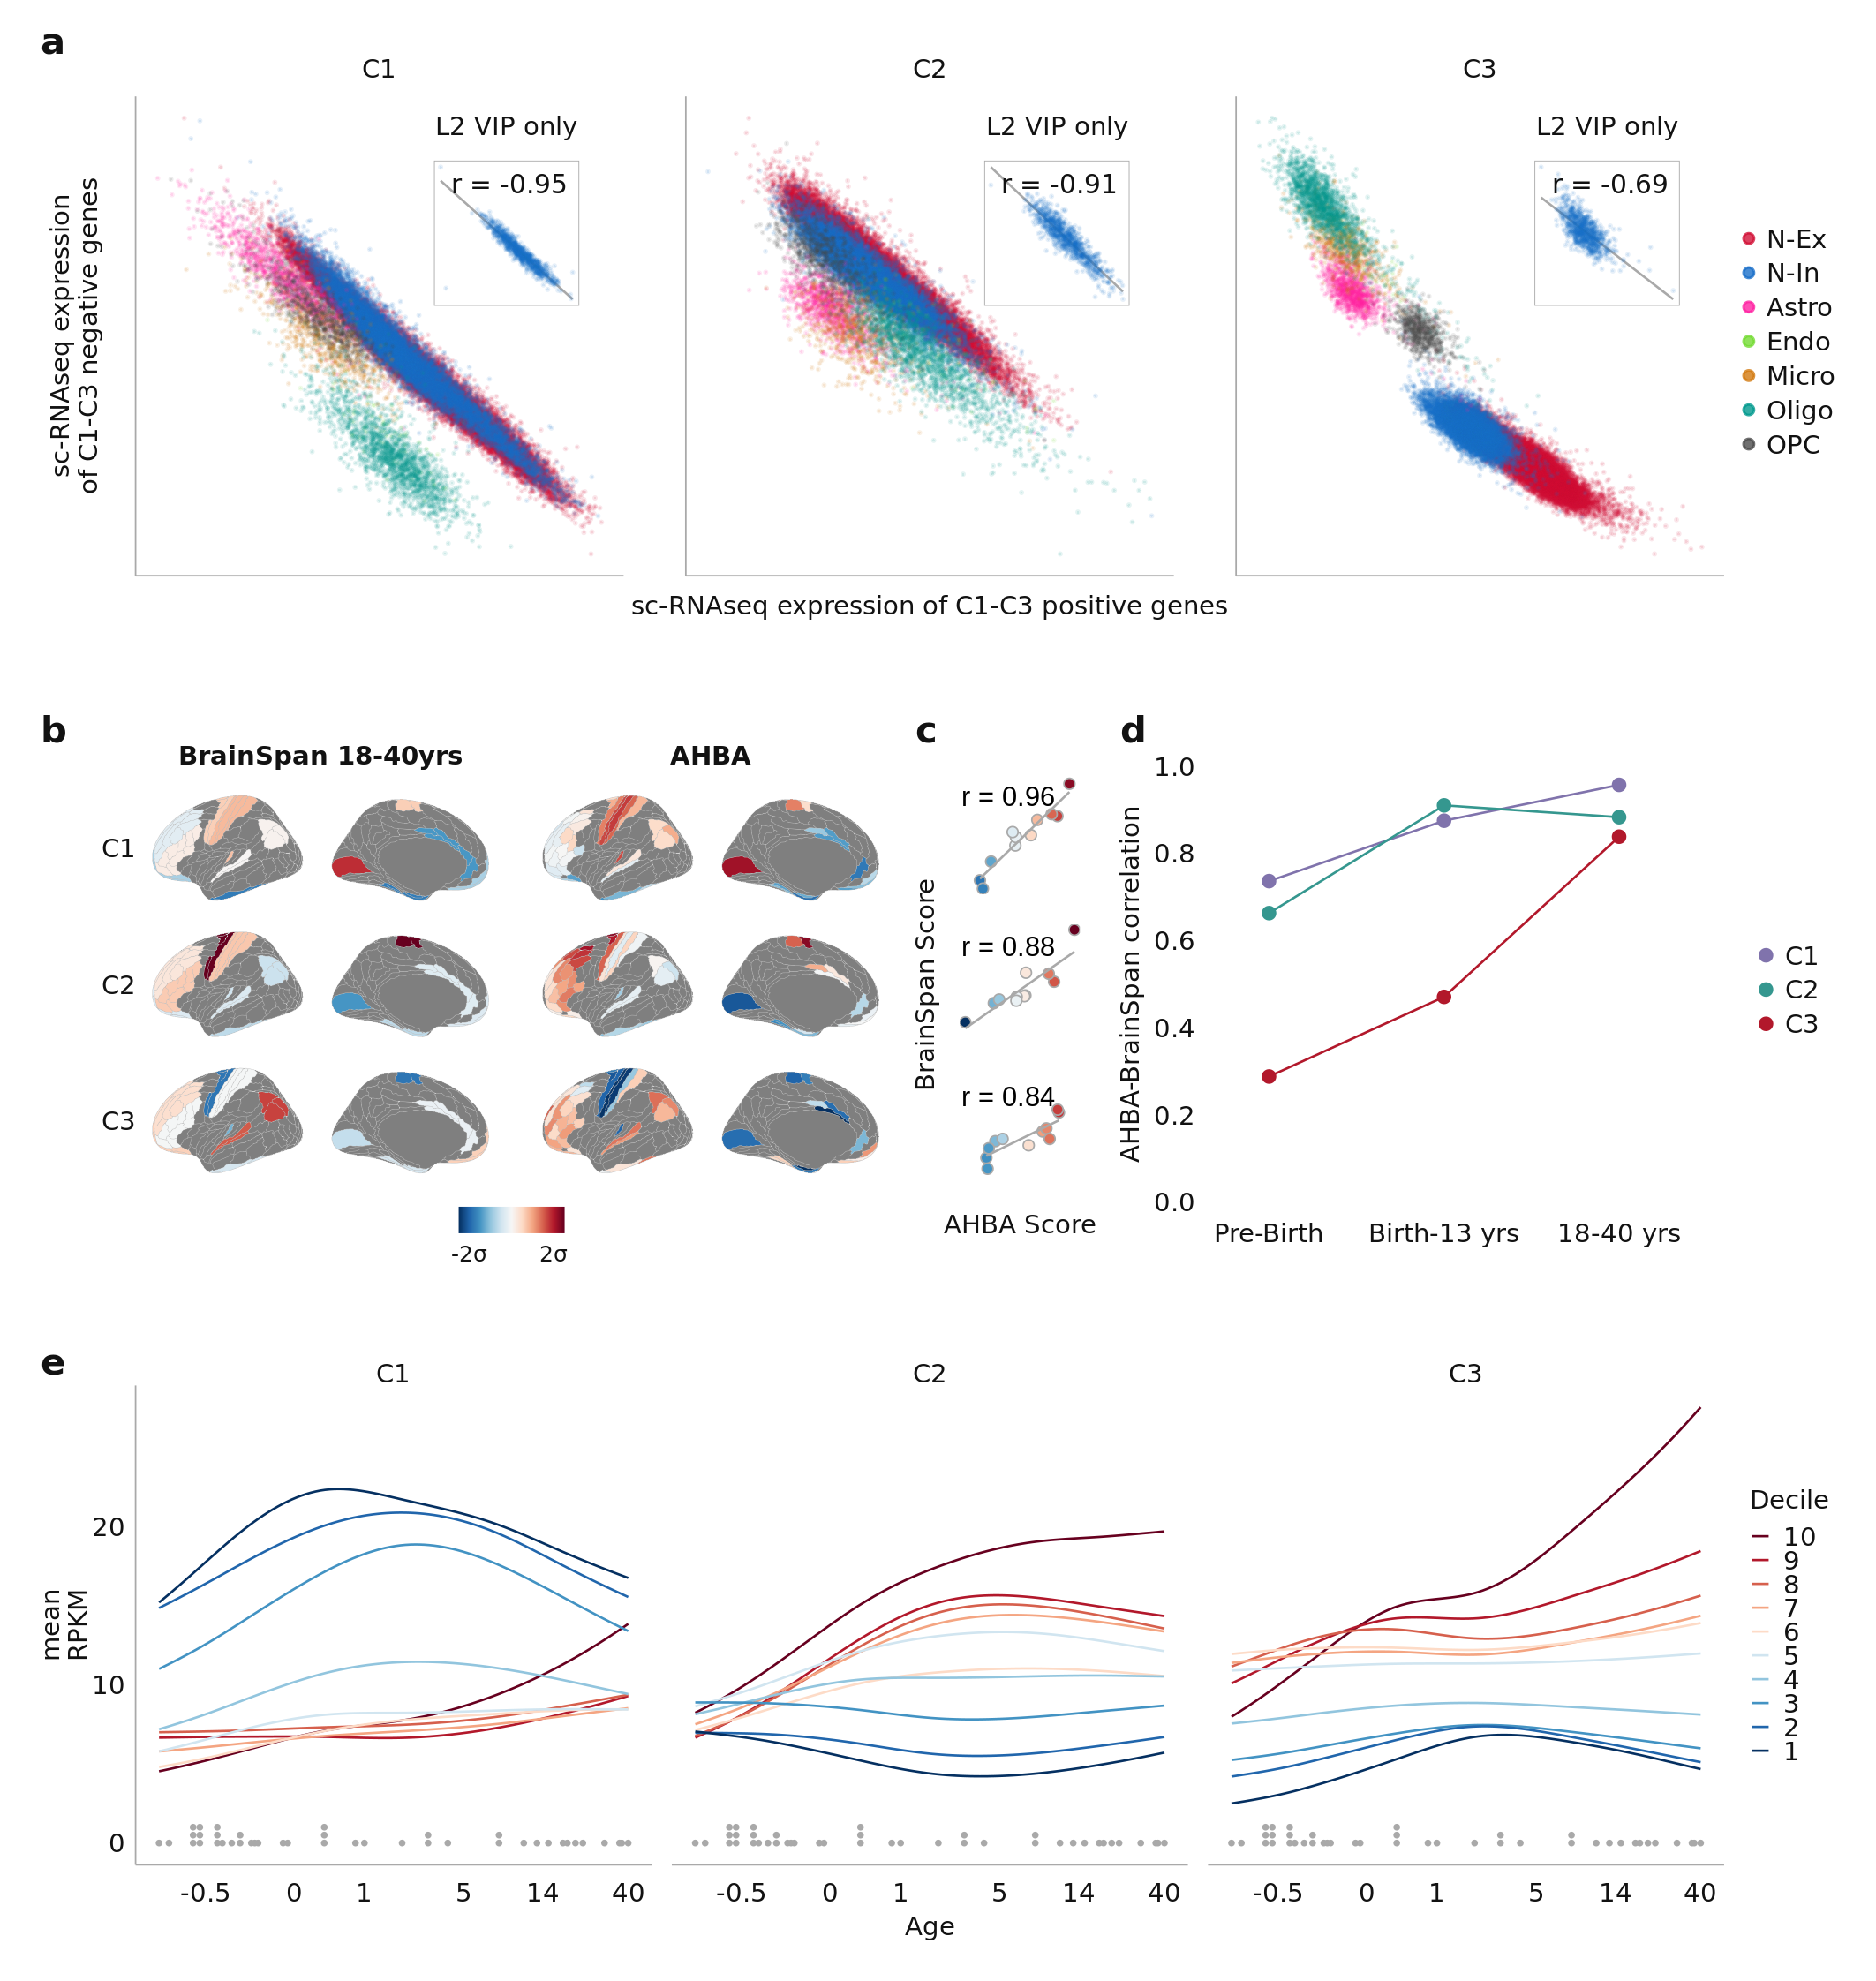

In [473]:
%%R -w 180 -h 190 -u mm -r 300 -i sc_projected_posneg_plot -i quantile_curves -i bs_donor_ages
source("../code/fig3_plots.R")

# plot_singlecell <- sc_projected_posneg_plot %>% plot_single_cell_posneg()
# plot_brainspan <- plot_brainspan & theme(plot.tag.position=c(0,.95))
plot_curves <- quantile_curves %>% plot_quantile_curves(donor_ages = bs_donor_ages)

design <- c(
    area(t=1,   b=60,  l=1, r=180),
    area(t=66,  b=125, l=1, r=180),
    area(t=131, b=190, l=1, r=180)
)
    
plot <- plot_singlecell + plot_brainspan + plot_curves + plot_layout(design=design)

themed <- plot & theme(legend.margin = margin(0,0,0,-2,'mm'))

annotated <- themed + plot_annotation(tag_level='a')
annotated

### (re-arrange panels for slides)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


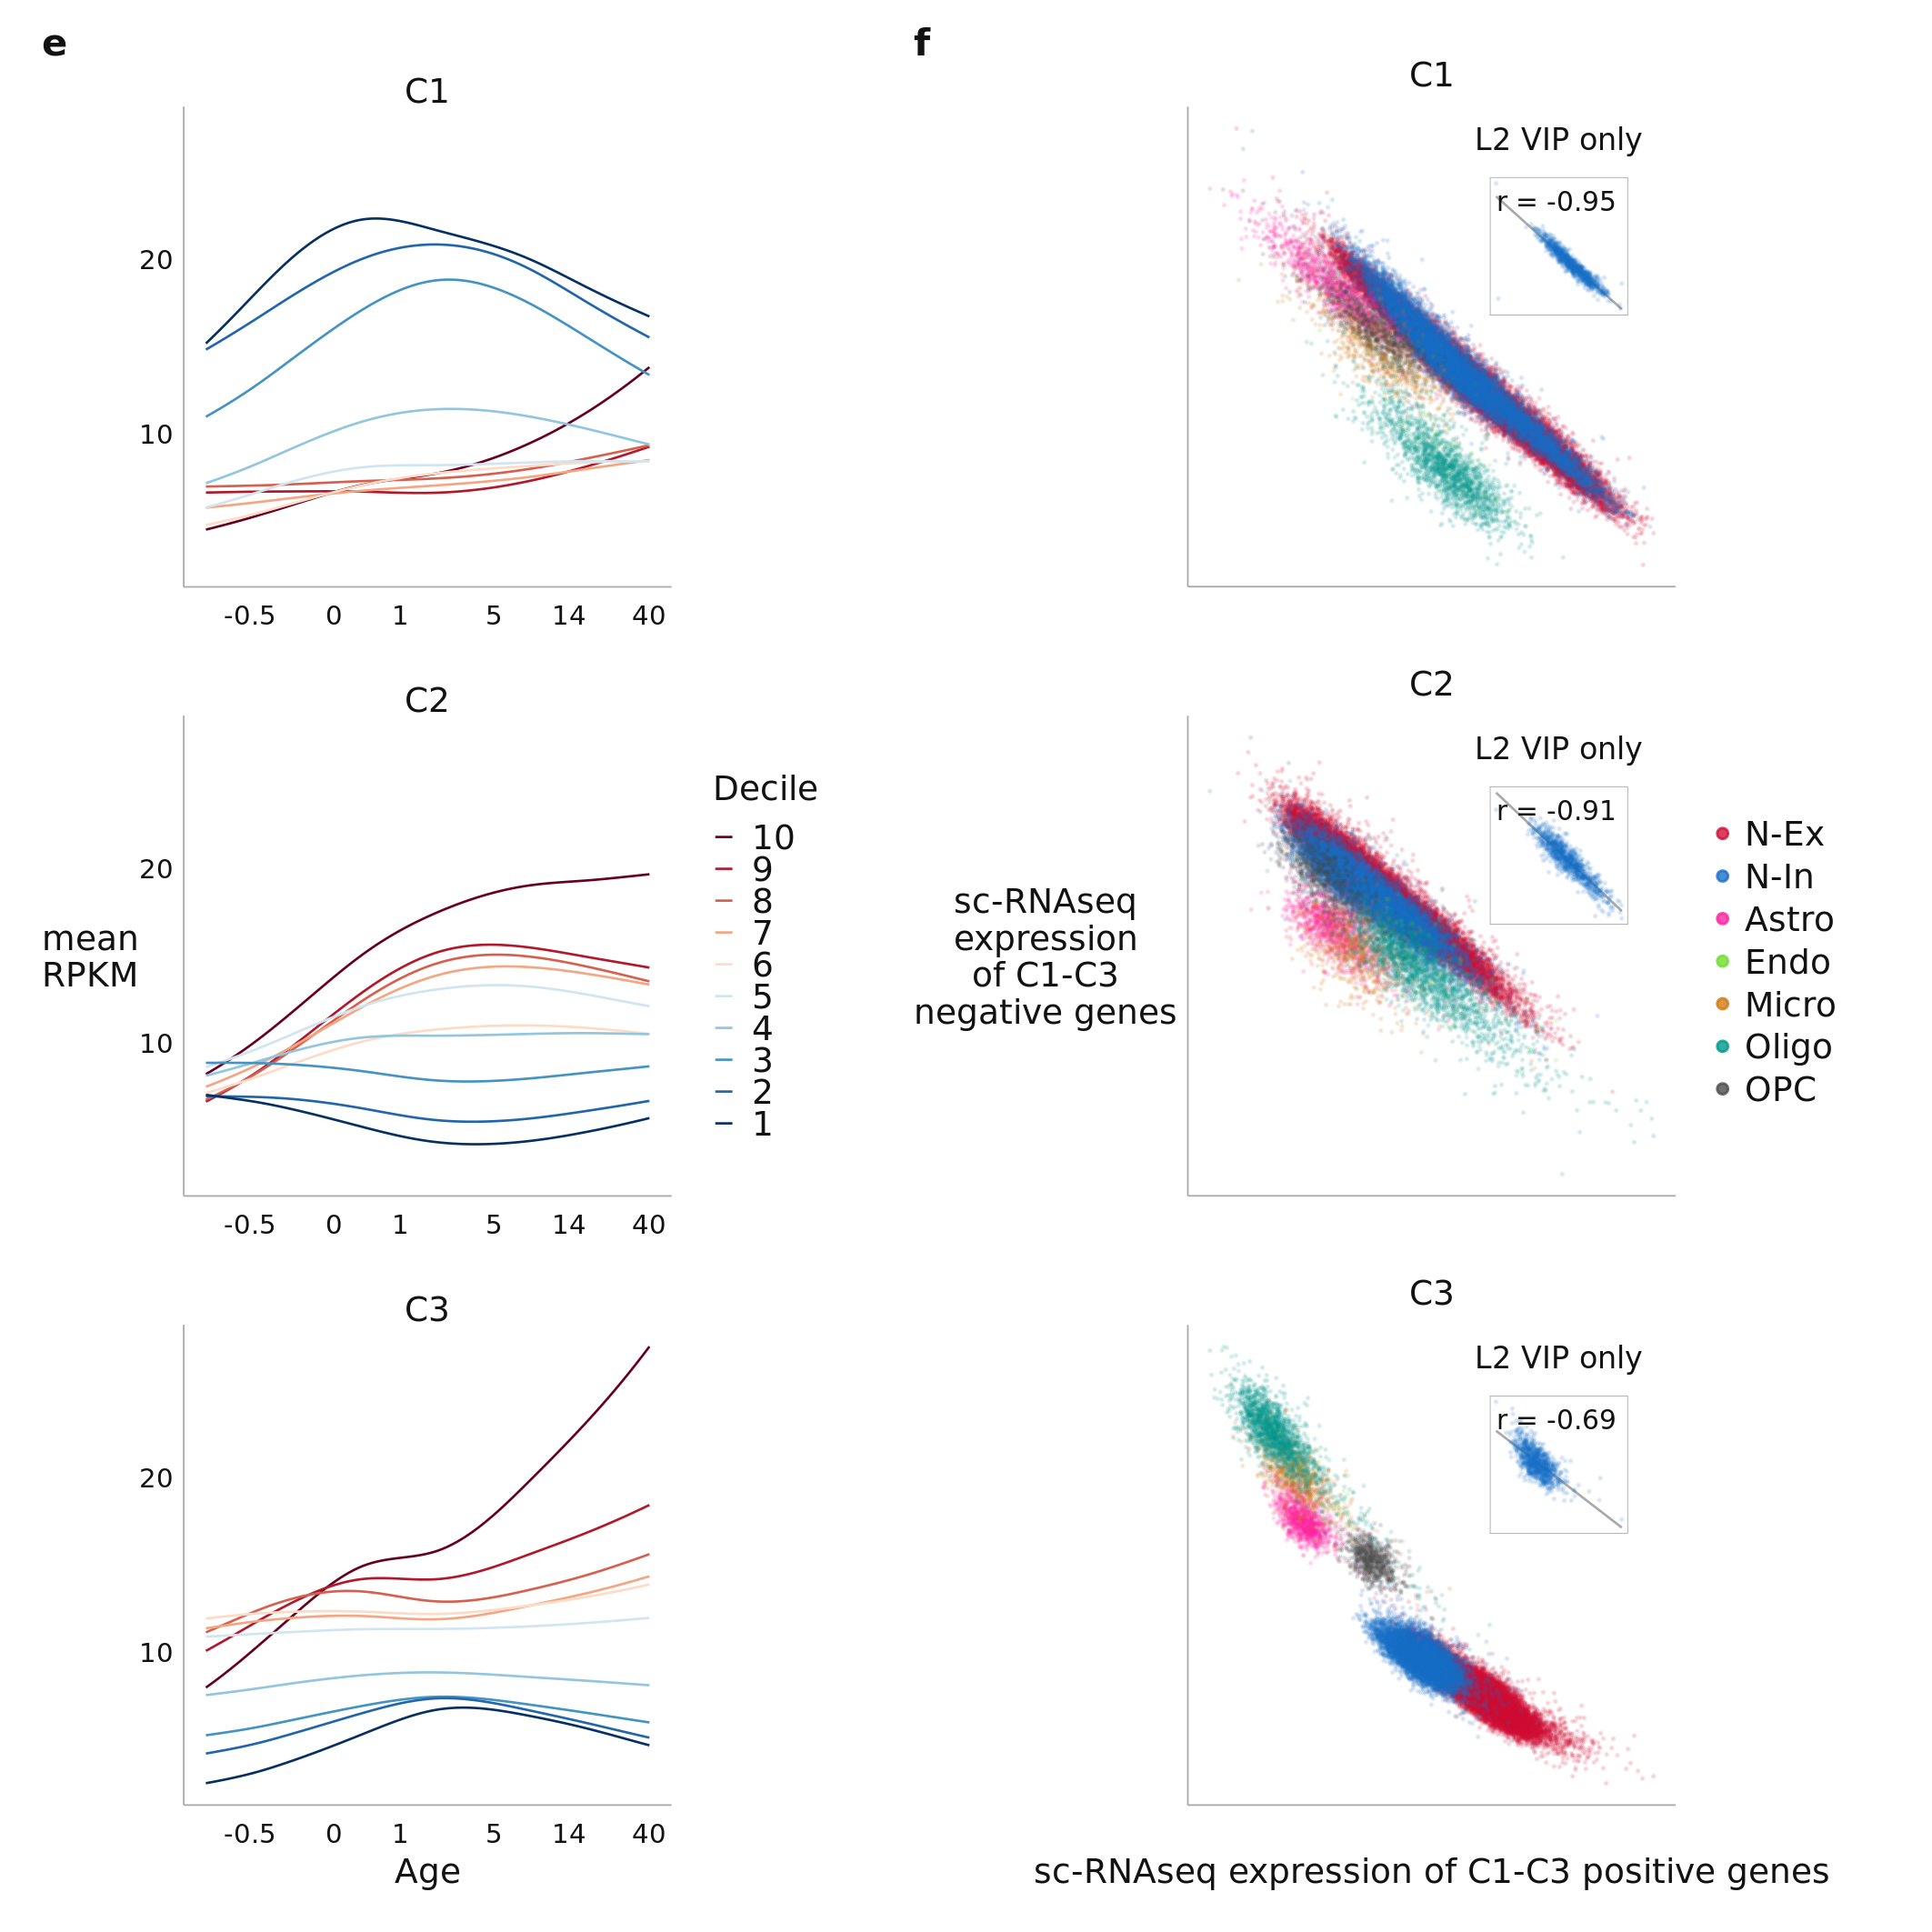

In [208]:
%%R -w 180 -h 180 -u mm -r 300 -i sc_projected_posneg_plot -i quantile_curves
source("../code/fig3_plots.R")

plot_singlecell <- sc_projected_posneg_plot %>% 
    plot_single_cell_posneg(ncol=1,
        ytitle_rmargin = 0,
        ylab = 'sc-RNAseq\nexpression\nof C1-C3\nnegative genes',
        xlab = 'sc-RNAseq expression of C1-C3 positive genes'
        ) + labs(tag='f')
# plot_brainspan <- plot_brainspan & theme(plot.tag.position=c(0,.95))
plot_curves <- quantile_curves %>% 
        plot_quantile_curves(ncol=1, ytitle_rmargin=0) + labs(tag='e')

design <- c(
    area(t=1,   b=180,  l=1, r=90),
    # area(t=66,  b=125, l=1, r=120),
    area(t=1, b=180, l=91, r=180)
)
    
plot <- plot_curves + plot_singlecell + plot_layout(design=design)

themed <- plot & theme(
    text = element_text(size=9),
    legend.text = element_text(size=9),
    strip.text = element_text(size=9),
    panel.spacing.y = unit(5, 'mm'),
    axis.title.y = element_text(angle=0, vjust=.5),
    legend.margin = margin(0,5,0,0,'mm'))

annotated <- themed
annotated